1. Import & Path

In [1]:
# 04_merge.ipynb — MERGE GOLD & BTC AT MONTHLY FREQUENCY (EOM)
# -----------------------------------------------------------------------
# Objective:
# - Ensure both series are at the End-Of-Month (EOM) index
# - Check for missing months
# - Inner join to get the common months
# - Save to data/interim/merged_gold_btc_monthly_2020_2025.csv
#
# API Source:
# - pandas.read_csv, DatetimeIndex.to_period/to_timestamp, Index.difference
# - Reference: pandas user guide (time series), SciPy is not used at this stage.

from pathlib import Path
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

INT = Path("data/interim")
assert (INT/"gold_monthly_clean_2020_2025.csv").exists(), "There is no interim Gold yet"
assert (INT/"btc_monthly_close_2020_2025.csv").exists(), "There is no interim BTC yet"

2. Theme & output paths

In [2]:
# THEME (color-blind friendly) + figure/table dirs
FIG = Path("reports/figures"); FIG.mkdir(parents=True, exist_ok=True)
TBL = Path("reports/tables");  TBL.mkdir(parents=True, exist_ok=True)

mpl.rcParams.update({
    "figure.figsize": (10, 6),
    "figure.dpi": 140,
    "font.size": 12,
    "font.family": "DejaVu Sans",
    "axes.titleweight": "bold",
    "axes.grid": True,
    "grid.color": "#D0D0D0",
    "grid.linestyle": "-",
    "grid.linewidth": 0.6,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.facecolor": "white",
    "savefig.bbox": "tight",
})

CBLUE   = "#0072B2"  # Gold line 
CORANGE = "#E69F00"  # BTC line
CGRAY   = "#666666"  # baseline/axis


3. Load & Align Index to EOM (End-of-Month)

In [3]:
gold = pd.read_csv(INT/"gold_monthly_clean_2020_2025.csv", parse_dates=["Date"]).set_index("Date")
btc  = pd.read_csv(INT/"btc_monthly_close_2020_2025.csv", parse_dates=["Date"]).set_index("Date")

# Make sure index = end of month & numeric type is clean
gold.index = gold.index.to_period("M").to_timestamp("M")
btc.index  = btc.index.to_period("M").to_timestamp("M")

# Desuplicate index if exist, drop NA, sort
gold = gold[~gold.index.duplicated(keep="last")].dropna().sort_index()
btc  = btc[~btc.index.duplicated(keep="last")].dropna().sort_index()

4. QC Missing Months & Visualization

Gold missing months : 5 [Timestamp('2025-08-31 00:00:00'), Timestamp('2025-09-30 00:00:00'), Timestamp('2025-10-31 00:00:00'), Timestamp('2025-11-30 00:00:00'), Timestamp('2025-12-31 00:00:00')]
BTC missing months  : 2 [Timestamp('2025-11-30 00:00:00'), Timestamp('2025-12-31 00:00:00')]


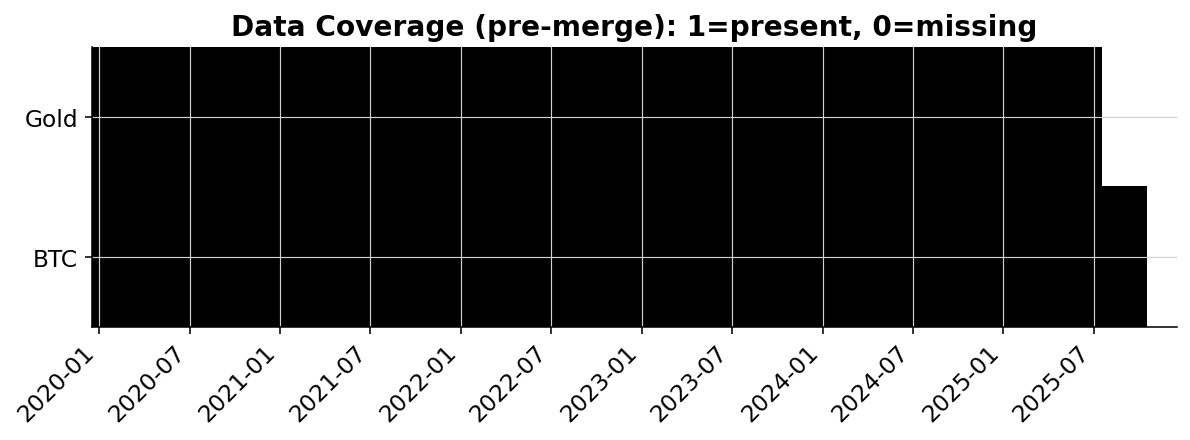

Saved -> C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\figures\04_premerge_coverage_heatmap.png


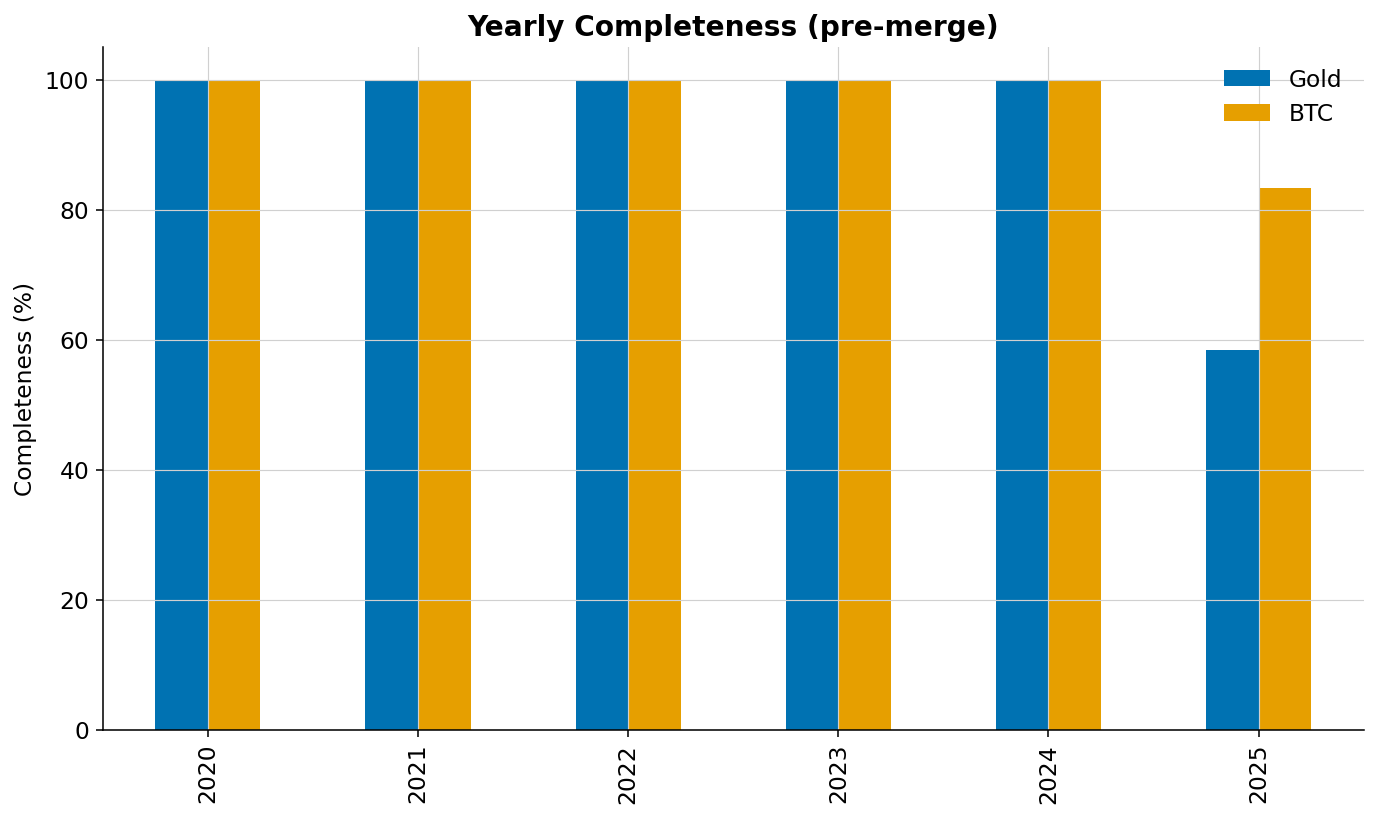

Saved -> C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\figures\04_premerge_yearly_completeness.png


In [4]:
expected = pd.period_range("2020-01","2025-12", freq="M").to_timestamp("M")
miss_gold = expected.difference(gold.index)
miss_btc  = expected.difference(btc.index)

print("Gold missing months :", len(miss_gold), list(miss_gold)[:6])
print("BTC missing months  :", len(miss_btc), list(miss_btc)[:6])

# QC Visual: Coverage Heatmap & Yearly Completeness
# Create Expectation Index 2020-01 - 2025-12
expected = pd.period_range("2020-01","2025-12", freq="M").to_timestamp("M")

cov = pd.DataFrame({
    "Gold": expected.isin(gold.index).astype(int),
    "BTC":  expected.isin(btc.index).astype(int),
}, index=expected)

# Coverage heatmap (1=present, 0=missing)
fig, ax = plt.subplots(figsize=(10, 2.6))
ax.imshow(cov.T, aspect="auto", cmap="Greys", interpolation="nearest")
ax.set_yticks([0,1]); ax.set_yticklabels(["Gold","BTC"])
ax.set_xticks(range(0, len(cov), 6))
ax.set_xticklabels([d.strftime("%Y-%m") for d in cov.index[::6]], rotation=45, ha="right")
ax.set_title("Data Coverage (pre-merge): 1=present, 0=missing")
plt.savefig(FIG/"04_premerge_coverage_heatmap.png", dpi=220)
plt.savefig(FIG/"04_premerge_coverage_heatmap.svg")
plt.show()
print("Saved ->", (FIG/"04_premerge_coverage_heatmap.png").resolve())

# Yearly completeness bar (proportion of months available per asset per year)
yr = cov.copy()
yr["year"] = yr.index.year
comp = yr.groupby("year")[["Gold","BTC"]].mean()*100
ax = comp.plot(kind="bar", color=[CBLUE, CORANGE])
ax.set_ylabel("Completeness (%)"); ax.set_xlabel("")
ax.set_title("Yearly Completeness (pre-merge)")
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig(FIG/"04_premerge_yearly_completeness.png", dpi=220)
plt.savefig(FIG/"04_premerge_yearly_completeness.svg")
plt.show()
print("Saved ->", (FIG/"04_premerge_yearly_completeness.png").resolve())


5. Merge (Inner Join) + Safe Range Filter

In [5]:
merged = gold.join(btc, how="inner").sort_index()
merged = merged.loc["2020-01-31":"2025-12-31"]

print("Merged shape  :", merged.shape)
print("Range         :", merged.index.min(), "->", merged.index.max())
print("NA counts     :\n", merged.isna().sum())
display(merged.head(3), merged.tail(3))

Merged shape  : (67, 2)
Range         : 2020-01-31 00:00:00 -> 2025-07-31 00:00:00
NA counts     :
 Gold_USD    0
BTC_USD     0
dtype: int64


,Gold_USD,BTC_USD
Date,,
2020-01-31,1560.67,9342.23
2020-02-29,1597.10,8545.45
2020-03-31,1591.93,6423.61


,Gold_USD,BTC_USD
Date,,
2025-05-31,3309.49,104696.46
2025-06-30,3352.66,107147.75
2025-07-31,3340.15,116009.40


6. Sanity plot level EOM

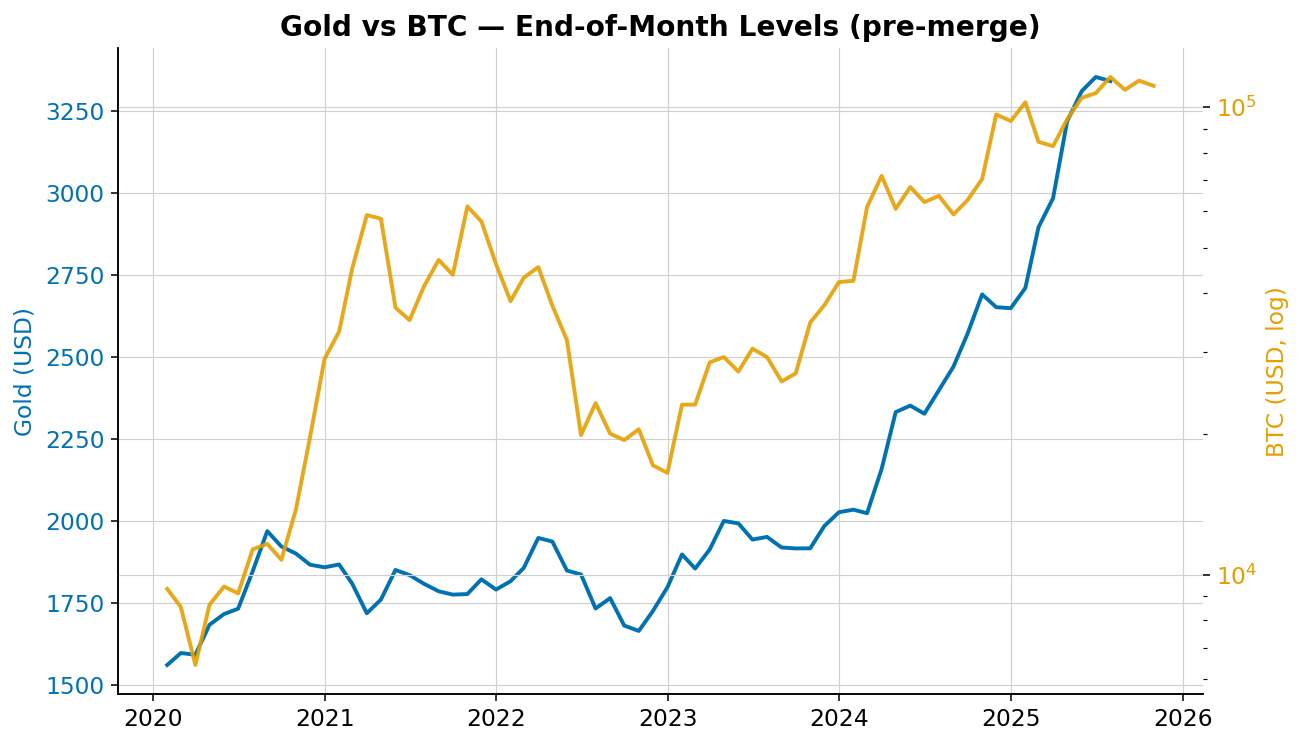

Saved -> C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\figures\04_levels_premerge_dualaxis.png


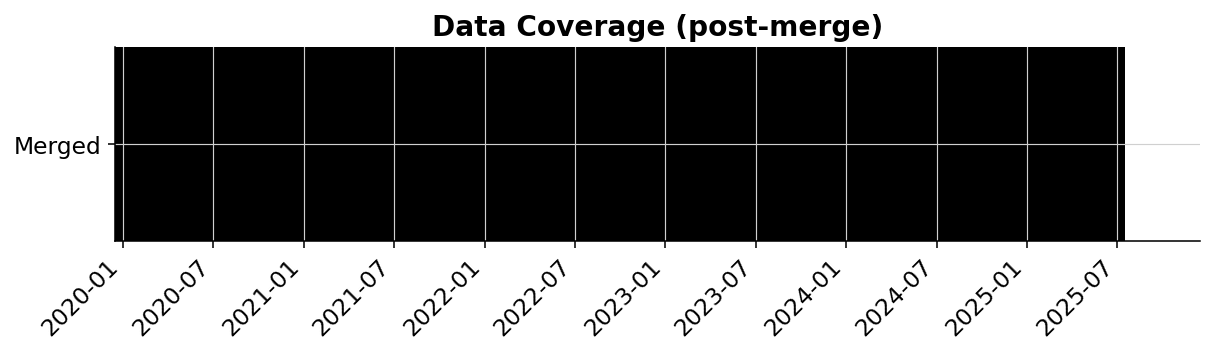

Saved -> C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\figures\04_postmerge_coverage_heatmap.png


In [6]:
# Sanity plots (EOM levels)
# Dual-axis: Gold (linear) vs BTC (log) for large BTC scales
fig, ax1 = plt.subplots()
ax1.plot(gold.index, gold["Gold_USD"], color=CBLUE, linewidth=2, label="Gold (USD)")
ax1.set_ylabel("Gold (USD)", color=CBLUE); ax1.tick_params(axis='y', labelcolor=CBLUE)
ax1.set_title("Gold vs BTC — End-of-Month Levels (pre-merge)")
ax1.set_xlabel("")

ax2 = ax1.twinx()
ax2.plot(btc.index, btc["BTC_USD"], color=CORANGE, linewidth=2, alpha=0.9, label="BTC (USD)")
ax2.set_ylabel("BTC (USD, log)", color=CORANGE); ax2.tick_params(axis='y', labelcolor=CORANGE)
ax2.set_yscale("log")

plt.savefig(FIG/"04_levels_premerge_dualaxis.png", dpi=220)
plt.savefig(FIG/"04_levels_premerge_dualaxis.svg")
plt.show()
print("Saved ->", (FIG/"04_levels_premerge_dualaxis.png").resolve())

# Coverage after MERGE (must inner join index merged)
cov_m = pd.Series(1, index=merged.index, name="Merged").reindex(expected).fillna(0)
fig, ax = plt.subplots(figsize=(10, 1.8))
ax.imshow(cov_m.values[np.newaxis, :], aspect="auto", cmap="Greys", interpolation="nearest")
ax.set_yticks([0]); ax.set_yticklabels(["Merged"])
ax.set_xticks(range(0, len(cov_m), 6))
ax.set_xticklabels([d.strftime("%Y-%m") for d in cov_m.index[::6]], rotation=45, ha="right")
ax.set_title("Data Coverage (post-merge)")
plt.savefig(FIG/"04_postmerge_coverage_heatmap.png", dpi=220)
plt.savefig(FIG/"04_postmerge_coverage_heatmap.svg")
plt.show()
print("Saved ->", (FIG/"04_postmerge_coverage_heatmap.png").resolve())


7. Save Merge Result & Summary QC

In [7]:
out_merged = INT/"merged_gold_btc_monthly_2020_2025.csv"
merged.to_csv(out_merged, index_label="Date")
print("Saved ->", out_merged.resolve())

# QC summary table (csv)
def _summ(df):
    return pd.Series({
        "rows": len(df),
        "start": df.index.min(),
        "end": df.index.max(),
        "na_total": int(df.isna().sum().sum())
    })

qc_tab = pd.DataFrame({
    "gold":   _summ(gold),
    "btc":    _summ(btc),
    "merged": _summ(merged)
}).round(0)

qc_tab.to_csv(TBL/"04_merge_qc_summary.csv")
print(qc_tab)
print("Saved ->", (TBL/"04_merge_qc_summary.csv").resolve())


Saved -> C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\data\interim\merged_gold_btc_monthly_2020_2025.csv
                         gold                  btc               merged
rows                       67                   70                   67
start     2020-01-31 00:00:00  2020-01-31 00:00:00  2020-01-31 00:00:00
end       2025-07-31 00:00:00  2025-10-31 00:00:00  2025-07-31 00:00:00
na_total                    0                    0                    0
Saved -> C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\tables\04_merge_qc_summary.csv
